# Machine Learning from Start to Finish with Scikit-Learn
## This tutorial uses [Titanic Survivors dataset from Kaggle](https://www.kaggle.com/c/titanic/data)
### September 6th 2019

In [90]:
### Import modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score

## 1) Read Input data

In [91]:
data_train=pd.read_csv('train.csv')
data_test= pd.read_csv('test.csv')

data_train.sample(3)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
459,460,0,3,"O'Connor, Mr. Maurice",male,NaN,0,0,371060,7.7500,NaN,Q
520,521,1,1,"Perreault, Miss. Anne",female,30.0,0,0,12749,93.5000,B73,S
67,68,0,3,"Crease, Mr. Ernest James",male,19.0,0,0,S.P. 3464,8.1583,NaN,S


In [92]:
data_test.sample(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
259,1151,3,"Midtsjo, Mr. Karl Albert",male,21.0,0,0,345501,7.7750,NaN,S
15,907,2,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.0,1,0,SC/PARIS 2167,27.7208,NaN,C
317,1209,2,"Rogers, Mr. Reginald Harry",male,19.0,0,0,28004,10.5000,NaN,S


## 2) Visualizing Data

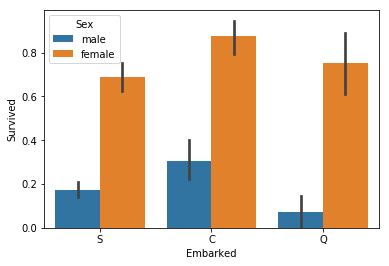

In [94]:
sns.barplot(x="Embarked",y="Survived",hue="Sex",data=data_train)

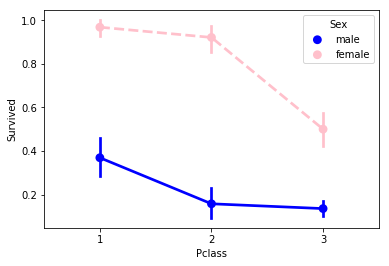

In [95]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex",data=data_train,
             palette={"male": "blue", "female": "pink"},linestyles=["-", "--"])

## 3) Transforming Features

In [96]:
data_train.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [97]:
data_train.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [98]:
def simplify_ages(df):
    df.Age= df.Age.fillna(-0.5)
    bins=(-1, 0, 5, 12, 18, 25,35,60,120)
    group_names= ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories= pd.cut(df.Age, bins, labels=group_names)
    df.Age= categories
    return df

# simplify_ages(df= data_train)

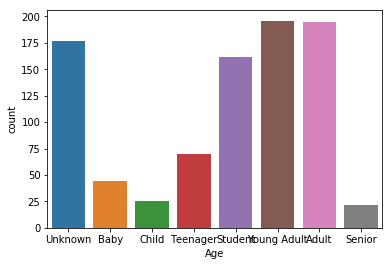

In [10]:
sns.countplot(x="Age",data=data_train)

In [99]:
def simplify_cabins(df):
    df.Cabin= df.Cabin.fillna('N')
    df.Cabin= df.Cabin.apply(lambda x: x[0])
    return df

# simplify_cabins(df= data_train)
# data_train

In [100]:
def simplify_fares(df):
    df.Fare= df.Fare.fillna(-0.5)
    bins= (-1,0,8,15,31,1000)
    group_names= ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories= pd.cut(df.Fare, bins, labels=group_names)
    df.Fare= categories
    return df

# simplify_fares(df=data_train)

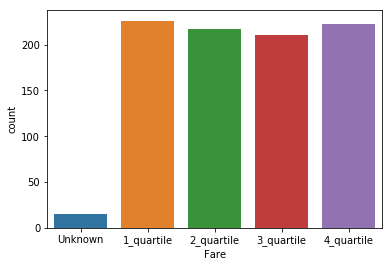

In [26]:
sns.countplot(x="Fare", data=data_train)

In [101]:
def format_name(df):
    df['Lname']= df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix']= df.Name.apply(lambda x: x.split(' ')[1])
    return df

# format_name(df= data_train)

In [102]:
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

# drop_features(df= data_train)

In [103]:
def transform_features(df):
    df= simplify_ages(df)
    df= simplify_cabins(df)
    df= simplify_fares(df)
    df= format_name(df)
    df= drop_features(df)
    return df

data_train= transform_features(data_train)
data_test= transform_features(data_test)
data_train.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.
5,6,0,3,male,Unknown,0,0,2_quartile,N,"Moran,",Mr.
6,7,0,1,male,Adult,0,0,4_quartile,E,"McCarthy,",Mr.
7,8,0,3,male,Baby,3,1,3_quartile,N,"Palsson,",Master.
8,9,1,3,female,Young Adult,0,2,2_quartile,N,"Johnson,",Mrs.
9,10,1,2,female,Teenager,1,0,3_quartile,N,"Nasser,",Mrs.


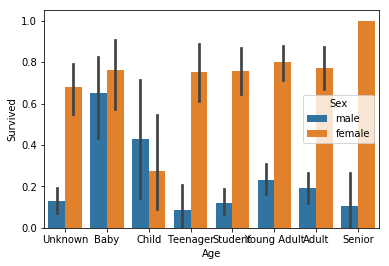

In [104]:
sns.barplot(x="Age", y="Survived",hue="Sex", data=data_train)

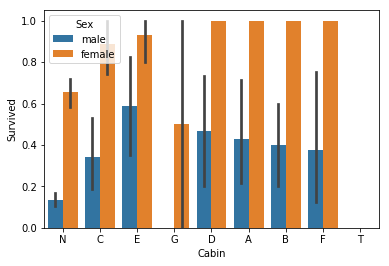

In [105]:
sns.barplot(x="Cabin", y="Survived",hue="Sex", data=data_train)

In [106]:
def encode_features(df_train, df_test):
    features= ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined= pd.concat([df_train[features], df_test[features]])
    for i in features: 
        le= preprocessing.LabelEncoder() #n-1 classes
        le=le.fit(df_combined[i]) #Fit label encoder
        df_train[i]= le.transform(df_train[i])
        df_test[i]= le.transform(df_test[i])
    return df_train, df_test

data_train, data_test= encode_features(df_train=data_train, df_test= data_test)


In [107]:
data_train.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19
5,6,0,3,1,6,0,0,1,7,538,19
6,7,0,1,1,0,0,0,3,4,500,19
7,8,0,3,1,1,3,1,2,7,608,13
8,9,1,3,0,7,0,2,1,7,382,20
9,10,1,2,0,5,1,0,2,7,559,20


## Splitting up the Training Data 

In [116]:
X_all= data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all= data_train['Survived']

num_test= 0.20
X_train, X_test, y_train, y_test= train_test_split(X_all, y_all, test_size= num_test, random_state=23)
print("X_train: ",X_train.shape, "\n")
print("X_test: ",X_test.shape, "\n")

X_train:  (712, 9) 

X_test:  (179, 9) 



## Train the RandomForest Classifier

In [123]:
### Use RandomForest:
clf=RandomForestClassifier()

### Choose some parameters and do grid search to find the best parameters
# 1) n_estimator=number of trees
# 2) max_features=The number of features to consider when looking for the best split
# 3) criterion= The function to measure the quality of a split
# 4) max_depth= The maximum depth of the tree
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

#Type of scoring used to compre parameter combinations: 
acc_score= make_scorer(score_func= accuracy_score)

### Run the Grid search: 
grid_obj = GridSearchCV(clf, parameters, scoring= acc_score)
grid_obj= grid_obj.fit(X_train, y_train)

# Set the best parameters to the Random Forest: 
clf=grid_obj.best_estimator_

#Fit the best algorithm to the data
clf.fit(X_train, y_train)


/home/razielar/miniconda3/envs/Tensorflow_1/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/razielar/miniconda3/envs/Tensorflow_1/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [125]:
predictions= clf.predict(X_test)
print("Accuracy:",accuracy_score(y_test, predictions))

Accuracy: 0.8156424581005587
